In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/tmp/ipykernel_1085685/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import glob,imp,os,shutil


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Plot $\sigma(p p \to \chi \chi)/\sigma(p p \to Z^{\prime}) \times BR(Z^{\prime} \to \chi \chi)$ from slha files


In [3]:
pcl2MDM = ['../2mdm_slhaCombined.pcl']
pclDMsimp = ['../dmsimp_slhaCombined.pcl']
dfs = [pd.read_pickle(i) for i in pcl2MDM]
dataDF_2mdm = pd.concat(dfs, ignore_index=True)
dfs = [pd.read_pickle(i) for i in pclDMsimp]
dataDF_dmsimp = pd.concat(dfs, ignore_index=True)

In [4]:
dataDF_2mdm.sort_values(['mass.9000006', 'mass.9900032'], inplace=True)
dataDF_dmsimp.sort_values(['mass.52', 'mass.55'], inplace=True)

In [5]:
couplingPair = [(0.1, 0.04), (1.0, 0.25), (1.0, 1.0)]

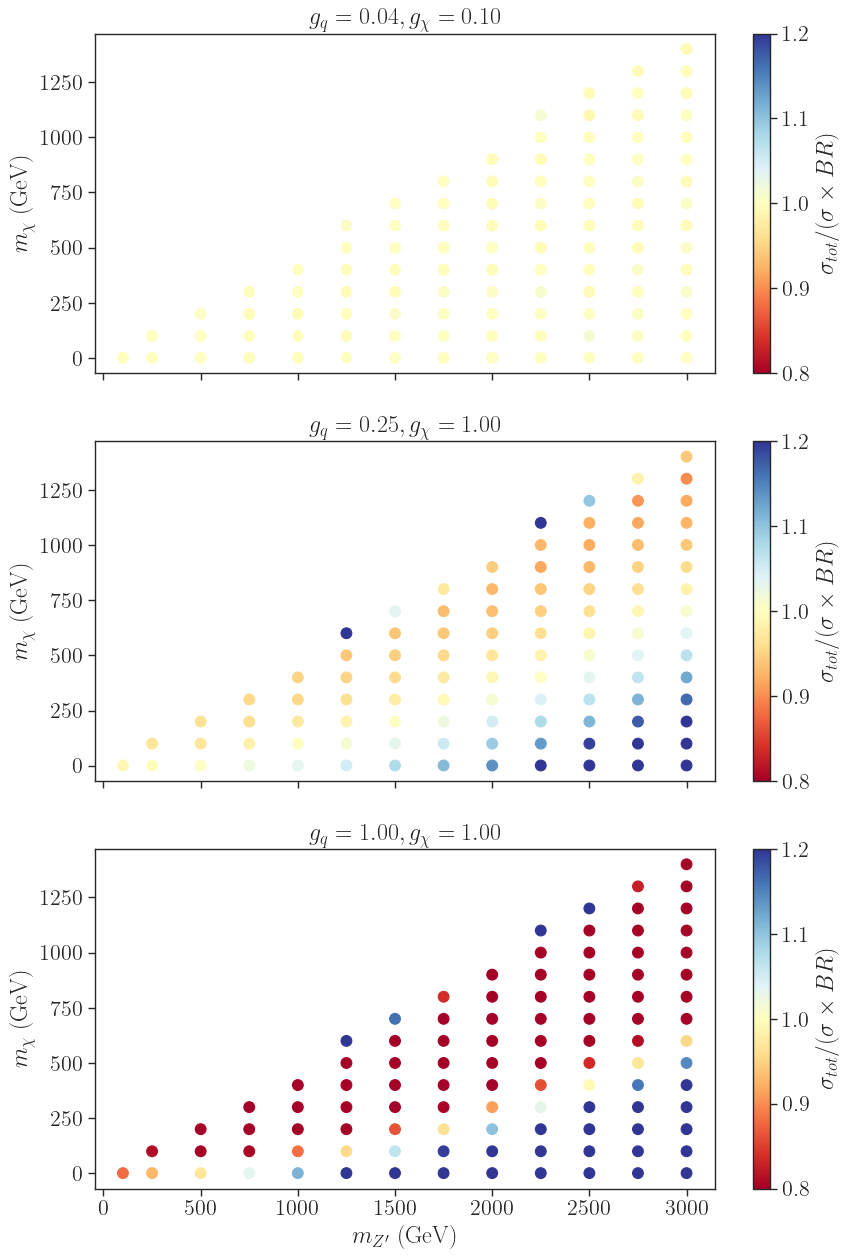

In [35]:
fig, ax = plt.subplots(3,sharex=True,figsize=(10,15))

for i, gs in enumerate(couplingPair):
    xsectot = np.array(dataDF_dmsimp['xsec13TeV(fb).52_52'][(dataDF_dmsimp['extpar.3']==gs[0])&(dataDF_dmsimp['extpar.10']==gs[1])])
    xsec = np.array(dataDF_2mdm['xsec13TeV(fb).9900032'][(dataDF_2mdm['extpar.1']==gs[0]*1.414214)&(dataDF_2mdm['extpar.3']==gs[1])])
    BR = np.array(dataDF_2mdm['BRs.zp.chi,chi'][(dataDF_2mdm['extpar.1']==gs[0]*1.414214)&(dataDF_2mdm['extpar.3']==gs[1])])
    xsecBR = xsec*BR
    
    x = dataDF_2mdm['mass.9900032'][(dataDF_2mdm['extpar.1']==gs[0]*1.414214)&(dataDF_2mdm['extpar.3']==gs[1])]
    y = dataDF_2mdm['mass.9000006'][(dataDF_2mdm['extpar.1']==gs[0]*1.414214)&(dataDF_2mdm['extpar.3']==gs[1])]
    z = xsectot/xsecBR
    
    sc = ax[i].scatter(x=x, y=y, c=z, s=60, cmap=cm, vmin=0.8, vmax=1.2)
    fig.colorbar(sc,ax=ax[i], label=r'$\sigma_{tot}/(\sigma \times BR)$')
    
    ax[i].set_ylabel(r'$m_{\chi}$ (GeV)')
    ax[i].set_title(r'$g_{q} = %1.2f, g_{\chi} = %1.2f$' %(gs[1], gs[0]))
    
ax[2].set_xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.savefig('../../figures/ratio-xsec-diff-widths.png')
plt.show()

### Plot branching ratios

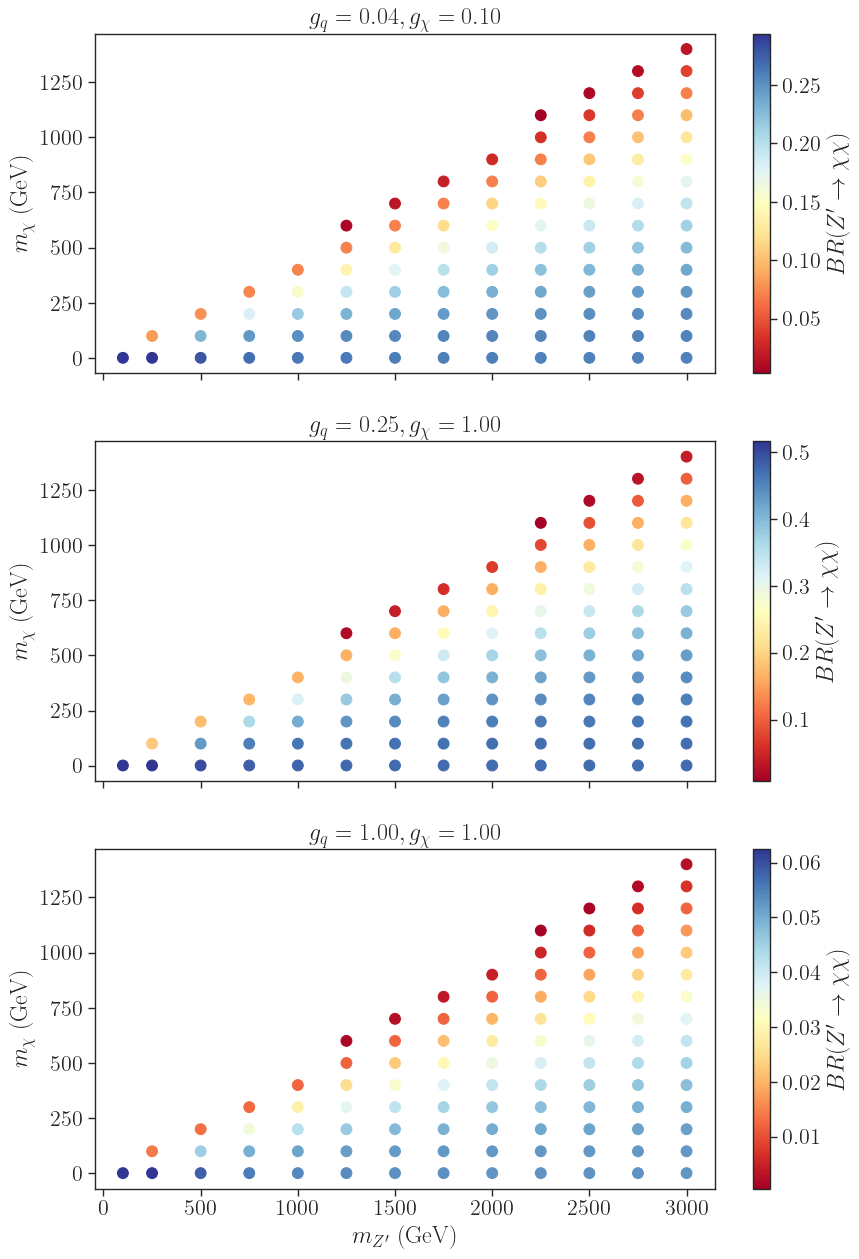

In [8]:
figs, ax = plt.subplots(3,sharex=True,figsize=(10,15))

for i, gs in enumerate(couplingPair):
    BR = np.array(dataDF_2mdm['BRs.zp.chi,chi'][(dataDF_2mdm['extpar.1']==gs[0]*1.414214)&(dataDF_2mdm['extpar.3']==gs[1])])

    
    x = dataDF_2mdm['mass.9900032'][(dataDF_2mdm['extpar.1']==gs[0]*1.414214)&(dataDF_2mdm['extpar.3']==gs[1])]
    y = dataDF_2mdm['mass.9000006'][(dataDF_2mdm['extpar.1']==gs[0]*1.414214)&(dataDF_2mdm['extpar.3']==gs[1])]
    z = BR
    
    sc = ax[i].scatter(x=x, y=y, c=z, s=60, cmap=cm)
    fig.colorbar(sc,ax=ax[i], label=r'$BR(Z^{\prime} \to \chi \chi)$')
    
    ax[i].set_ylabel(r'$m_{\chi}$ (GeV)')
    ax[i].set_title(r'$g_{q} = %1.2f, g_{\chi} = %1.2f$' %(gs[1], gs[0]))
#     ax[i].set_ylim(-50, 1450)
    
ax[2].set_xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.show()

## Plot $r_{tot}/r_{(\sigma*BR)}$ from SModelS

In [17]:
pcl2MDM = ['../smodels_results_widths_2mdm/2mdm_results_widths.pcl']
pclDMsimp = ['../smodels_results_widths_dmsimp/dmsimp_results_widths.pcl']
dfs = [pd.read_pickle(i) for i in pcl2MDM]
newDF_2mdm = pd.concat(dfs, ignore_index=True)
dfs = [pd.read_pickle(i) for i in pclDMsimp]
newDF_dmsimp = pd.concat(dfs, ignore_index=True)

In [18]:
#Set points without results with r == 0
newDF_2mdm.fillna(value={c : 0 for c in newDF_2mdm.columns if c.endswith('.r')}, inplace=True)
newDF_dmsimp.fillna(value={c : 0 for c in newDF_dmsimp.columns if c.endswith('.r')}, inplace=True)

In [19]:
newDF_2mdm.sort_values(['mass.9000006', 'mass.9900032'], inplace=True)
newDF_dmsimp.sort_values(['mass.52', 'mass.55'], inplace=True)

/tmp/ipykernel_1085685/3193433953.py:10: RuntimeWarning: invalid value encountered in divide
  z = rtot/rsigmabr


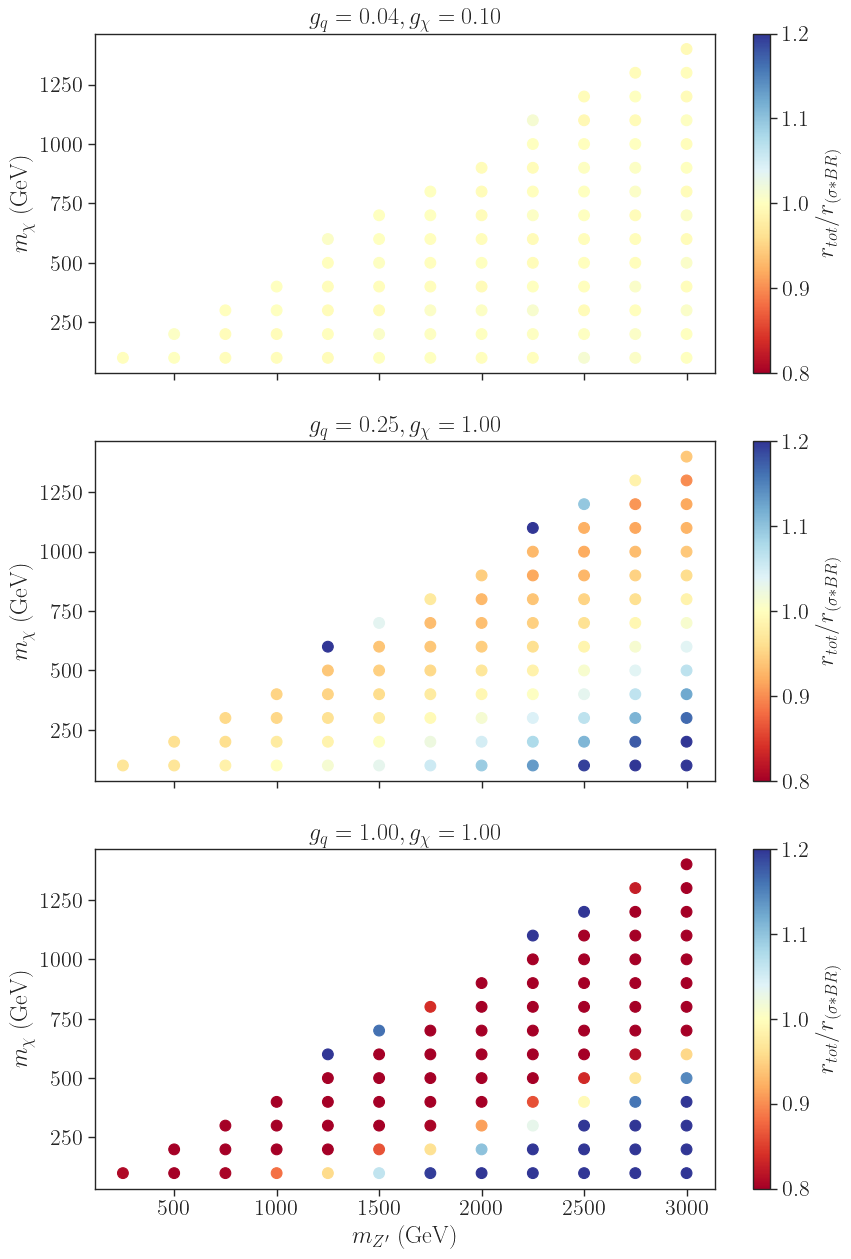

In [25]:
fig, ax = plt.subplots(3,sharex=True,figsize=(10,15))

for i, gs in enumerate(couplingPair):
    
    rtot = np.array(newDF_dmsimp['ExptRes.result0.r'][(newDF_dmsimp['extpar.3']==gs[0])&(newDF_dmsimp['extpar.10']==gs[1])])
    rsigmabr = np.array(newDF_2mdm['ExptRes.result0.r'][(newDF_2mdm['extpar.1']==gs[0]*1.414214)&(newDF_2mdm['extpar.3']==gs[1])])
    
    x = newDF_2mdm['mass.9900032'][(newDF_2mdm['extpar.1']==gs[0]*1.414214)&(newDF_2mdm['extpar.3']==gs[1])]
    y = newDF_2mdm['mass.9000006'][(newDF_2mdm['extpar.1']==gs[0]*1.414214)&(newDF_2mdm['extpar.3']==gs[1])]
    z = rtot/rsigmabr
    
    sc = ax[i].scatter(x=x, y=y, c=z, s=60, cmap=cm, vmin=0.8, vmax=1.2)
    fig.colorbar(sc,ax=ax[i], label=r'$r_{tot}/r_{(\sigma*BR)}$')
    
    ax[i].set_ylabel(r'$m_{\chi}$ (GeV)')
    ax[i].set_title(r'$g_{q} = %1.2f, g_{\chi} = %1.2f$' %(gs[1], gs[0]))
    
ax[2].set_xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.savefig('../../figures/ratio-different-widths.png')
plt.show()